<a href="https://colab.research.google.com/github/heosooyoun/LLM/blob/main/3_6_%EB%A9%80%ED%8B%B0%ED%97%A4%EB%93%9C_%EC%96%B4%ED%85%90%EC%85%98_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3.6 싱글 헤드 어텐션을 멀티 헤드 어텐션으로 확장하기


####3.6.1 여러 개의 싱글 헤드 어텐션 층 쌓기

- 실제로는 입력벡터의 크기(차원)와 문맥벡터(결과)의 크기(차원)가 같다.



In [34]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias =False):
    super().__init__()
    self.heads = nn.ModuleList(
        #파이썬의 리스트 내포 함수를 이용하여 헤드 갯수만큼 반복
        #ModuleList: 모듈 여러개를 리스트처럼 관리 가능
        [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

  def forward(self, x):
    #코젤 어텐션을 하나씩 뽑아서 입력값 x를 넣어 호출
    #cat: 토치의 메소트, dim=-1-> 마지막 차원을 따라서 이어붙
      return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # 토큰 개수
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


#### 3.6.2 가중치 분할로 멀티 헤드 어텐션 구현하기

- 아래의 그림은 위의 코드를 구현한 것
  - 가중치 행렬을 쿼리 키, 벨류 가중치 행렬을 따로 만들어서 각각 쿼리와 헤드를 향한 쿼리를 각각 만드는 것

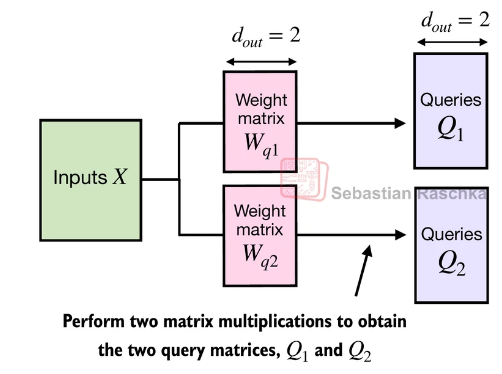

- 가중치 행렬을 헤드 갯수만금 크게 만들고 쿼리를 만들고 나눠서 사용할 수 있지 않을까(한번의 행렬 연산을 나누기)

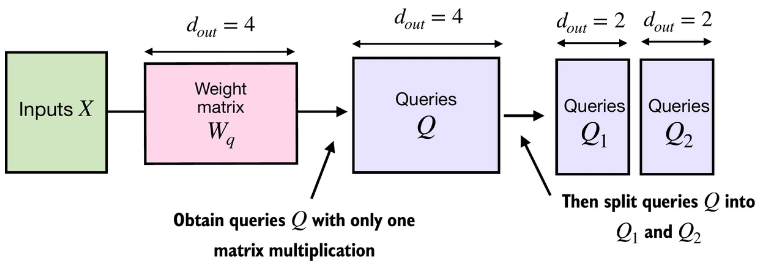

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out은 num_heads로 나누어 떨어져야 합니다"

        self.d_out = d_out
        self.num_heads = num_heads
        # 원하는 출력 차원에 맞도록 투영 차원을 낮춥니다.
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Linear 층을 사용해 헤드의 출력을 결합합니다.
        # 문맥 벡터의 크기와 동일하게 맞춰준다
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # `CausalAttention`과 마찬가지로, 입력의 `num_tokens`가 `context_length`를 넘는 경우 마스크 생성에서 오류가 발생합니다.
        # 실제로는 forward 메서드에 들어오기 전에 LLM이 입력이 `context_length`를
        # 넘지 않는지 확인하기 때문에 문제가 되지 않습니다.

        keys = self.W_key(x) # 크기: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)  #쿼리, 키, 벨류 만들기

        # `num_heads` 차원을 추가함으로써 암묵적으로 행렬을 분할합니다.
        # 그다음 마지막 차원을 `num_heads`에 맞춰 채웁니다: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        #d_out 문맥벡터의 크기를 헤드 갯수(num_heads) 만큼 나눠준다.
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # 전치: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # 헤드 별로 계산하기 위해서
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # 코잘 마스크로 스케일드 점곱 어텐션(셀프 어텐션)을 계산합니다.
        attn_scores = queries @ keys.transpose(2, 3)  # 각 헤드에 대해 점곱을 수행합니다.

        # 마스크를 불리언 타입으로 만들고 토큰 개수로 마스크를 자릅니다.
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # 마스크를 사용해 어텐션 점수를 채웁니다.
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 크기: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # 헤드를 결합합니다. self.d_out = self.num_heads * self.head_dim
        # num_heads 헤드 갯수와 head_dim헤드 차원으로 나뉘어 있던 것을 다시
        # d_out으로 view 메소드를 이용해 합쳐준다.
        # view 메소드를 사용하기 위해 contiguous 메소드를 사용해서 메모리를 복사해서 순서대로 정렬
        # transpose 메소드는 참조값만 변경하기 때문에 위같은 작업 필요
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # 투영 - 리니어 사용

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


attn_scores = queries @ keys.transpose(2, 3)가 실행될 때

In [ ]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

# 2,3번을 전치하면 a.transpose(2, 3) = (1,2,4,3)
# a는 그대로 (1, 2, 3, 4)
print(a @ a.transpose(2, 3)) # 두개를 곱하면 (1,2,3,3)
# 헤드 2개마다 각각 3개의 원소를 갖고있는 3차원 행렬 두개가 된다

위의 코딩은 헤드 각각을 꺼내서 반복하는 것과 결과가 같다

In [ ]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("첫 번째 헤드:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\n두 번째 헤드:\n", second_res)